# Tutorial: Numerical implementation of neutrino leakage scheme

## Author: Leo Werneck

<a id=toc></a>

# Table of Contents
$$\label{toc}$$

1. [Step 1](#calc_leak_f90): `calc_leak.F90` <font color='green'>**FINISHED**</font>
    1. [Step 1.a](#zelmanileak_calcleak): `ZelmaniLeak_CalcLeak()`
    1. [Step 1.b](#calc_leak): `calc_leak()`
    1. [Step 1.c](#linterp): `linterp()`
    1. [Step 1.d](#linterp2dn): `linterp2Dn()`
    1. [Step 1.e](#linterp3dn): `linterp3Dn()`
1. [Step 2](#calc_taus_f90): calc_taus.F90
    1. [Step 2.a](#get_fermi_integral_leak): `get_fermi_integral_leak()`
1. [Step 3](#ye_of_rho_f90): `ye_of_rho.F90` <font color='green'>**FINISHED**</font>
    1. [Step 3.a](#zelmanileak_ye_of_rho): `ZelmaniLeak_ye_of_rho()`
    1. [Step 3.b](#fit_ye): `fit_ye()`
    1. [Step 3.c](#zelmanileak_calc_entropy): `ZelmaniLeak_calc_entropy()`
1. [Step 4](#ye_of_rho_from_profile_f90): `ye_of_rho_from_profile.F90` <font color='green'>**FINISHED**</font>
    1. [Step 4.a](#yeofrho): `yeofrho()`
    1. [Step 4.b](#readprofile_ye): `readprofile_ye()`
    1. [Step 4.c](#setuprho_ye): `setuprho_ye()`
    1. [Step 4.d](#setupye_ye): `setupye_ye()`
    1. [Step 4.e](#map_find_index_ye): `map_find_index_ye()`
    1. [Step 4.f](#linterp_ye): `linterp_ye()`
1. [Step 5](#calc_grr_cc): `calc_grr.cc` <font color='green'>**FINISHED**</font>
    1. [Step 5.a](#zltau_calc_grr): `ZLtau_calc_grr()`
1. [Step 6](#tau_cc): `tau.cc` <font color='green'>**FINISHED**</font>
    1. [Step 6.a](#zltau_setup_local): `ZLtau_setup_local()`
    1. [Step 6.b](#zltau_register): `ZLtau_register()`
    1. [Step 6.c](#zltau_setup): `ZLtau_setup()`
1. [Step 7](#tau_hh): `tau.hh` <font color='green'>**FINISHED**</font>
    1. [Step 7.a](#spher2cart): `spher2cart()`
1. [Step 8](#neutrino_pressure_c): `neutrino_pressure.c` <font color='green'>**FINISHED**</font>
    1. [Step 8.a](#zelmanileak_calcpnu_wrapper): `ZelmaniLeak_CalcPnu()`
1. [Step 9](#calc_pnu_f90): `calc_pnu.F90` <font color='green'>**FINISHED**</font>
    1. [Step 9.a](#zelmanileak_calcpnu_impl): `ZelmaniLeak_CalcPnu()`
1. [Step 10](#startup_f90): `startup.F90` <font color='green'>**FINISHED**</font>
    1. [Step 10.a](#zelmanileak_startup): `ZelmaniLeak_startup()`
    1. [Step 10.b](#zelmanileak_startup_global): `ZelmaniLeak_startup_global()`
1. [Step 11](#paramcheck_c): `paramcheck.c` <font color='green'>**FINISHED**</font>
    1. [Step 11.a](#zelmanileak_paramcheck): `ZelmaniLeak_ParamCheck()`
1. [Step 12](#tmunu_f90): `Tmunu.F90` <font color='green'>**FINISHED**</font>
    1. [Step 12.a](#zelmanileak_tmunu): `ZelmaniLeak_Tmunu()`

<font color='orange'>**IN PROGRESS**</font> - calc_taus.F90<br>
<font color='red'>**PENDING**</font> - helpers.cc<br>
<font color='green'>**FINISHED**</font> - calc_leak.F90<br>
<font color='green'>**FINISHED**</font> - Tmunu.F90<br>
<font color='green'>**FINISHED**</font> - calc_grr.cc<br>
<font color='green'>**FINISHED**</font> - calc_pnu.F90<br>
<font color='green'>**FINISHED**</font> - neutrino_pressure.c<br>
<font color='green'>**FINISHED**</font> - paramcheck.c<br>
<font color='green'>**FINISHED**</font> - startup.F90<br>
<font color='green'>**FINISHED**</font> - tau.cc<br>
<font color='green'>**FINISHED**</font> - tau.hh<br>
<font color='green'>**FINISHED**</font> - ye_of_rho.F90<br>
<font color='green'>**FINISHED**</font> - ye_of_rho_from_profile.F90

<a id=calc_leak_f90></a>

# Step 1: `calc_leak.F90` \[Back to [Top](#toc)\]
$$\label{calc_leak_f90}$$

$$
\newcommand{\RR}{\mathcal{R}}
\newcommand{\QQ}{\mathcal{Q}}
\newcommand{\nui}{\nu_{i}}
\newcommand{\anui}{\bar{\nu}_{i}}
\newcommand{\nux}{\nu_{\rm x}}
\newcommand{\anux}{\bar{\nu}_{\rm x}}
\newcommand{\nue}{\nu_{\rm e}}
\newcommand{\anue}{\bar{\nu}_{\rm e}}
\newcommand{\mb}{m_{\rm b}}
\newcommand{\me}{m_{\rm e}}
\newcommand{\nb}{n_{\rm b}}
\newcommand{\ne}{n_{\rm e}}
\newcommand{\rhob}{\rho_{\rm b}}
\newcommand{\ye}{Y_{\rm e}}
\newcommand{\Fdual}{{}^{*}\!F}
\newcommand{\ee}{e^{-}}
\newcommand{\ae}{e^{+}}
\newcommand{\pnu}{P_{\rm neutrinos}}
\newcommand{\rholeak}{\rho_{\rm leak}}
\newcommand{\dt}{\Delta t}
\newcommand{\avg}[1]{\langle#1\rangle}
\newcommand{\rms}[1]{\langle#1^{2}\rangle}
$$

<a id=zelmanileak_calcleak></a>

## Step 1.a: `ZelmaniLeak_CalcLeak()` \[Back to [Top](#toc)\]
$$\label{zelmanileak_calcleak}$$

This function can be enabled in the premerger by setting the parameter `leak_in_premerger` to "yes" in the parameter file. It defaults to disabled.

Provided the input density is above the leakage threshold density, i.e., $\rhob > \rholeak$, and we are inside the radius where the leakage scheme takes place, i.e., $r < r_{\rm leak}$, then leakage is enabled. We start by computing

$$
\begin{aligned}
\theta &= {\rm acos}\left(\frac{z}{x+\varepsilon}\right),\\
\phi &= {\rm atan2}(y,x+\varepsilon),
\end{aligned}
$$

where $\varepsilon=10^{-10}$ is used to avoid dividing by zero and ${\rm atan2}$ is the ["2-argument arctangent"](https://en.wikipedia.org/wiki/Atan2).

Next, the quantities $\chi_{\nui}$, $\tau_{\nui}$, $H_{\nui}$, $E^{\rm ef}_{\nui}$, and $\epsilon_{\nui}$ are interpolated to $(r,\theta,\phi)$ using the linear interpolation routines described below.

This setup allow us to call the function `calc_leak()` (see [Step 1.b](#calc_leak) below), after which we compute

$$
\begin{aligned}
\ye &\to \ye + \frac{\delta\ye}{\delta t}\dt,\\
\epsilon &\to \epsilon + \frac{\delta\epsilon}{\delta t}\dt,
\end{aligned}
$$

where the quantities $\delta\ye/\delta t$ and $\delta\epsilon/\delta t$ are calculated in the `calc_leak()` function.

<a id=calc_leak></a>

## Step 1.b: `calc_leak()` \[Back to [Top](#toc)\]
$$\label{calc_leak}$$

This is a core function in the `ZelmaniLeak` thorn, computing key quantities of the leakage scheme. We describe the contents of the function below in reverse order, i.e., if you want to follow the implementation you should start by reading the end of this cell and work your way back to the beginning. By default, it is responsible for computing the source terms

$$
\begin{align}
\RR &= -\RR^{\rm eff}(\nue)+\RR^{\rm eff}(\anue),\\
\QQ &= -\QQ^{\rm eff}(\nue)+\QQ^{\rm eff}(\anue)+\QQ^{\rm eff}(\nux),
\end{align}
$$

where $\RR$ and $\QQ$ is the neutrino emission and cooling rates, respectively. The effective emission and cooling rates, $\RR^{\rm eff}(\nui)$ and $\QQ^{\rm eff}(\nui)$, respectively, are defined below. Alternatively, we can also enable heating, modifying the source terms as

$$
\begin{align}
\RR &\to \RR - \RR^{\rm heat},\\
\QQ &\to \QQ - \QQ^{\rm heat},
\end{align}
$$

where $\QQ^{\rm heat}$ is the total neutrino heating rate, i.e.,

$$
\begin{align}
\QQ^{\rm heat} &= -\QQ^{\rm heat}(\nue) + \QQ^{\rm heat}(\anue),\\
\RR^{\rm heat} &= -\frac{\QQ^{\rm heat}(\nue)}{\avg{\epsilon_{\nue}}} + \frac{\QQ^{\rm heat}(\anue)}{\avg{\epsilon_{\anue}}},
\end{align}
$$

where the average energies $\avg{\epsilon_{\nui}}$ are given by

$$
\avg{\epsilon_{\nui}} = T\frac{F_{5}(\eta_{\nui})}{F_{4}(\eta_{\nui})},
$$

and (cf. Eq. 31 in [O'Connor & Ott (2010)](https://arxiv.org/abs/0912.2393))

$$
Q^{\rm heat}(\nui) = f_{\rm heat}F_{\rm heat}(\nui)\sigma_{\rm heat}(\nui)\frac{\rhob}{m_{\rm u}}X_{i}\left[4.275\tau(\nui)+1.15\right]e^{-2\tau(\nui)}.
$$

In the above equation, $f_{\rm heat}$ is a user-specified *ad hoc* parameter that allows us to control the heating rate (defaults to 1, but see [O'Connor & Ott (2010a)](https://pos.sissa.it/100/154/pdf) for tests with other values) , $m_{\rm u}$ is the atomic mass unit, $X_{i}$ is the mass fraction, with $X_{i}=X_{\rm n}$ for $\nui=\nue$ and $X_{i}=X_{\rm p}$ for $\nui=\anue$, $\tau(\nui)$ is the optical depth, and

$$
\begin{align}
F_{\rm heat}(\nui) &= \frac{L_{\nui}(r)}{4\pi r^{2}},\\
\sigma_{\rm heat}(\nue) &= \frac{1+3g_{A}^{2}}{4}\sigma_{0}\frac{\rms{\epsilon_{\nue}}}{(\me c^{2})^{2}}\left[1-f_{\nue}\right]_{\rm ec},\\
\sigma_{\rm heat}(\anue) &= \frac{1+3g_{A}^{2}}{4}\sigma_{0}\frac{\rms{\epsilon_{\anue}}}{(\me c^{2})^{2}}\left[1-f_{\nue}\right]_{\rm pc},
\end{align}
$$

where $F_{\rm heat}$ is the heat flux (computed in `calc_tau.F90`; the implementation includes the blocking factors $\left[1-f_{\nui}\right]$ in the heat fluxes instead of the heat cross sections) and $\sigma_{\rm heat}$ is the heat cross section. The blocking factors are computed using (cf. Eqs. A9 and A10 of [Galleazi *et al.* (2013)](https://arxiv.org/abs/1306.4953))

$$
\begin{align}
\left[1-f_{\nue}\right]_{\rm ec} &\approx \left\{1 + \exp\left[-\frac{F_{5}(\eta_{\rm e})}{F_{4}(\eta_{\rm e})}-\eta_{\nue}\right]\right\}^{-1},\\
\left[1-f_{\anue}\right]_{\rm pc} &\approx \left\{1 + \exp\left[-\frac{F_{5}(-\eta_{\rm e})}{F_{4}(-\eta_{\rm e})}-\eta_{\anue}\right]\right\}^{-1},
\end{align}
$$

and the root-mean-square energies $\rms{\epsilon_{\nui}}$ are computed using

$$
\rms{\epsilon_{\nui}} = T^{2}\frac{F_{5}(\nui)}{F_{3}(\nui)}.
$$

The effective rates $\RR^{\rm eff}$ and $\QQ^{\rm eff}$ are given by (cf. Eqs. A1 and A2 in [Rosswog & Liebendörfer (2003)](https://arxiv.org/abs/astro-ph/0302301))

$$
\begin{align}
\RR^{\rm eff}(\nui) &= \RR^{\rm free}_{\rm total}(\nui)\left[1+\frac{\RR^{\rm free}_{\rm total}(\nui)}{\RR^{\rm diff}(\nui)}\right]^{-1},\\
\QQ^{\rm eff}(\nui) &= \QQ^{\rm free}_{\rm total}(\nui)\left[1+\frac{\QQ^{\rm free}_{\rm total}(\nui)}{\QQ^{\rm diff}(\nui)}\right]^{-1},
\end{align}
$$

where the free emission and heating rates are given by

$$
\begin{align}
\RR^{\rm free}_{\rm total}(\nui) &= \RR^{\rm free}_{\beta}(\nui) + \RR^{\rm free}_{\ee,\ae}(\nui) + \RR^{\rm free}_{\gamma}(\nui) + \RR^{\rm free}_{\rm Br},\\
\QQ^{\rm free}_{\rm total}(\nui) &= \QQ^{\rm free}_{\beta}(\nui) + \QQ^{\rm free}_{\ee,\ae}(\nui) + \QQ^{\rm free}_{\gamma}(\nui) + \RR^{\rm free}_{\rm Br},
\end{align}
$$

where the subscripts $\beta$, $\ee,\ae$, $\gamma$, and ${\rm Br}$ correspond to $\beta$-processes (electron/positron capture), which only contribute for the electron neutrinos and antineutrinos, electron-positron pair annihilation, plasmon decay, and [Bremsstrahlung](https://en.wikipedia.org/wiki/Bremsstrahlung). The emission rates are given by

$$
\begin{align}
%%%
\RR^{\rm free}_{\rm ec}(\nue) &= \nb^{-1}\beta\,\eta_{\rm np}T^{5}F_{4}(\eta_{\rm e})\left[1-f_{\nue}\right]_{\rm ec},\\
%%%
\RR^{\rm free}_{\rm pc}(\anue) &= \nb^{-1}\beta\,\eta_{\rm np}T^{5}F_{4}(-\eta_{\rm e})\left[1-f_{\anue}\right]_{\rm pc},\\
%%%
\RR^{\rm free}_{\ee,\ae}(\nue,\anue) &= \frac{(C_{1}+C_{2})_{\nue\anue}}{36\nb}\frac{\sigma_{0}c}{\me^{2}c^{4}}
\epsilon_{4}(\ae)\epsilon_{4}(\ee)\left[1-f_{\nue}(\eta_{\rm e},\eta_{\nue})\right]_{\ae\ee}\left[1-f_{\anue}(\eta_{\rm e},\eta_{\anue})\right]_{\ae\ee},\\
%%%
\RR^{\rm free}_{\ae\ee}(\nux,\anux) &= \frac{(C_{1}+C_{2})_{\nux\anux}}{9\nb}\frac{\sigma_{0}c}{\me^{2}c^{4}}
\epsilon_{4}(\ae)\epsilon_{4}(\ee)\left[1-f_{\anux}(\eta_{\rm e},\eta_{\nux})\right]_{\ae\ee},\\
%%%
\RR^{\rm free}_{\gamma}(\nue,\anue) &= \nb^{-1}\frac{\pi^{3}}{3\alpha_{\rm f}}C_{V}^{2}\frac{\sigma_{0}c}{\me^{2}c^{4}}\gamma^{6}\frac{T^{8}}{(hc)^{6}}\exp(-\gamma)(1+\gamma)\left[1+f_{\nue}(\eta_{\rm e},\eta_{\nue})\right]_{\gamma}\left[1+f_{\anue}(-\eta_{\rm e},\eta_{\anue})\right]_{\gamma},\\
%%%
\RR^{\rm free}_{\gamma}(\nux,\anux) &= \nb^{-1}\frac{4\pi^{3}}{3\alpha_{\rm f}}(C_{V}-1)^{2}\frac{\sigma_{0}c}{\me^{2}c^{4}}\gamma^{6}\frac{T^{8}}{(hc)^{6}}\exp(-\gamma)(1+\gamma)\left[1+f_{\nux}(\eta_{\rm x},\eta_{\nux})\right]_{\gamma},\\
%%%
\RR^{\rm free}_{\rm Br}(\nui,\anui) &= q_{i}(0.231\times2.0778\times10^{30})f_{\rm Br}\left(X_{\rm n}^{2}+X_{\rm p}^{2} + \frac{28}{3}X_{\rm n}X_{\rm p}\right)\rho_{14}^{2} T^{4.5},
%%%
\end{align}
$$

where $q_{i}=1$ for the electron neutrino/antineutrino and $q_{i}=4$ for heavi lepton neutrinos, $f_{\rm Br}=0.5$, and $\rho_{14} = \rhob/10^{14}$ with $\rhob$ in units of $\mathrm{g\,cm^{-3}}$. The above quantities are all defined in detail in the [tutorial notebook on the neutrino leakage formulation](Tutorial-Neutrino_leakage-Formulation.ipynb), coming from [Ruffert *et al* (1996)](https://adsabs.harvard.edu/pdf/1996A%26A...311..532R) using the notation of [Galleazi *et al.* (2013)](https://arxiv.org/abs/1306.4953), except for the last expression which comes from [O'Connor & Ott (2010a)](https://pos.sissa.it/100/154/pdf).

Similarly, the heating rates are given by

$$
\begin{align}
%%%
\QQ^{\rm free}_{\rm ec}(\nue) &= \nb^{-1}\beta\,\eta_{\rm np}T^{6}F_{5}(\eta_{\rm e})\left[1-f_{\nue}\right]_{\rm ec},\\
%%%
\QQ^{\rm free}_{\rm pc}(\anue) &= \nb^{-1}\beta\,\eta_{\rm np}T^{6}F_{5}(-\eta_{\rm e})\left[1-f_{\anue}\right]_{\rm pc},\\
%%%
\QQ^{\rm free}_{\ee,\ae}(\nue,\anue) &= \RR_{\ae\ee}(\nui,\anui)\frac{\epsilon_{5}(\ee)\epsilon_{4}(\ae) + \epsilon_{4}(\ee)\epsilon_{5}(\ae)}{\epsilon_{4}(\ee)\epsilon_{4}(\ae)},\\
%%%
\QQ^{\rm free}_{\gamma}(\nui,\anui) &= \RR^{\rm free}_{\gamma}(\nui,\anui)T\left[1 + \frac{\gamma^{2}}{2(1+\gamma)}\right],\\
%%%
\QQ^{\rm free}_{\rm Br}(\nui,\anui) &= q_{i}(0.504\times2.0778\times10^{30})f_{\rm Br}\left(X_{\rm n}^{2}+X_{\rm p}^{2} + \frac{28}{3}X_{\rm n}X_{\rm p}\right)\rho_{14}^{2} T^{5.5}.
%%%
\end{align}
$$

In the above we use the following identities:

$$
\begin{align}
\beta &= \frac{\pi}{h^{3}c^{2}}\frac{1+3\alpha^{2}}{\me^{2} c^{4}}\sigma_{0},\\
n_{\rm np} &= \frac{n_{\rm n}-n_{\rm p}}{e^{\hat\eta}-1},\\
(C_{1}+C_{2})_{\nue\anue} &= \left(C_{V}-C_{A}\right)^{2} + \left(C_{V}+C_{A}\right)^{2},\\
(C_{1}+C_{2})_{\nux\anux} &= (C_{V}-C_{A})^{2} + (C_{V}+C_{A}-2)^{2},\\
\epsilon_{N}\bigl(e^{\mp}\bigr) &= \frac{8\pi}{(hc)^{3}}T^{N}F_{N-1}\bigl(\pm\eta_{\rm e}\bigr),\\
F_{N}(z) &= \int_{0}^{\infty}\frac{x^{N}dx}{e^{x-z}+1},\\
\eta_{\rm e} &= \mu_{\rm e}/T,\\
\eta_{\rm p} &= \mu_{\rm p}/T,\\
\eta_{\rm n} &= \mu_{\rm n}/T,\\
\hat\eta &= \eta_{\rm n} - \eta_{\rm p} - Q/T,\\
\eta_{\nue} &= \eta_{\rm e} - \eta_{\rm n} + \eta_{\rm p},\\
\eta_{\anue} &= -\eta_{\nue},\\
\eta_{\nux} &= 0,
\end{align}
$$

where $Q=m_{\rm n}-m_{\rm p}=1.2935\ {\rm MeV}$, $C_{A}=1/2$, and $C_{V}=0.962$.

<a id=linterp></a>

## Step 1.c: `linterp()` \[Back to [Top](#toc)\]
$$\label{linterp}$$

This function performs [linear interpolation](https://en.wikipedia.org/wiki/Linear_interpolation) of a function $f$. The function returns

$$
f(x) = f_{\rm in}(x_{1}) + \left(\frac{f_{\rm in}(x_{2})-f_{\rm in}(x_{1})}{x_{2}-x_{1}}\right)(x-x_{1}).
$$

<a id=linter3></a>

## Step 1.d: `linterp3()` \[Back to [Top](#toc)\]
$$\label{linterp3}$$

This function is a rewrite of the function `linterp()` that takes as input vectors $\left(\vec{x}_{1},\vec{x}_{2},\vec{y}_{1},\vec{y}_{2}\right)$ and computes

$$
\vec{y} = \vec{y}_{1} + \left(\frac{\vec{y}_{2}-\vec{y}_{1}}{\vec{x}_{2}-\vec{x}_{1}}\right)(\vec{x}-\vec{x}_{1}).
$$

<a id=linterp2dn></a>

## Step 1.e: `linterp2Dn()` \[Back to [Top](#toc)\]
$$\label{linterp2dn}$$

This function performs [bilinear interpolation](https://en.wikipedia.org/wiki/Bilinear_interpolation) of a function $f$. Let $Q_{ij} = (x_{i},y_{j})$. The function returns

$$
f_{\rm out}(x,y) = \frac{f_{\rm in}(Q_{11})(x_{2}-x)(y_{2}-y) + f_{\rm in}(Q_{21})(x-x_{1})(y_{2}-y) + f_{\rm in}(Q_{12})(x_{2}-x)(y-y_{1}) + f_{\rm in}(Q_{22})(x-x_{1})(y-y_{1})}{(x_{2}-x_{1})(y_{2}-y_{1})}.
$$

<a id=linterp3dn></a>

## Step 1.f: `linterp3Dn()` \[Back to [Top](#toc)\]
$$\label{linterp3dn}$$

This function performs [trilinear interpolation](https://en.wikipedia.org/wiki/Trilinear_interpolation) of a function $f$. Let $Q_{ijk} = (x_{i},y_{j},z_{k})$. The function returns

$$
\begin{split}
f_{\rm out}(x,y,z) = \left[(x_{2}-x_{1})(y_{2}-y_{1})(z_{2}-z_{1})\right]^{-1}
\big[&f_{\rm in}(Q_{111})(x_{2}-x)(y_{2}-y)(z_{2}-z)\\
+&f_{\rm in}(Q_{211})(x-x_{1})(y_{2}-y)(z_{2}-z)\\
+&f_{\rm in}(Q_{121})(x_{2}-x)(y-y_{1})(z_{2}-z)\\
+&f_{\rm in}(Q_{112})(x_{2}-x)(y_{2}-y)(z-z_{1})\\
+&f_{\rm in}(Q_{221})(x-x_{1})(y-y_{1})(z_{2}-z)\\
+&f_{\rm in}(Q_{212})(x-x_{1})(y_{2}-y)(z-z_{1})\\
+&f_{\rm in}(Q_{122})(x_{2}-x)(y-y_{1})(z-z_{1})\\
+&f_{\rm in}(Q_{222})(x-x_{1})(y-y_{1})(z-z_{1})
\big]
\end{split}.
$$

<a id=calc_taus_f90></a>

# Step 2: `calc_taus.F90` \[Back to [Top](#toc)\]
$$\label{calc_taus_f90}$$

This file contains 3 functions:

* `ZelmaniLeak_CalcTau()`
* `calc_taus()`
* `get_fermi_integral_leak()`

<a id=zelmanileak_calctau></a>

## Step 2.a: `ZelmaniLeak_CalcTau()` \[Back to [Top](#toc)\]
$$\label{zelmanileak_calctau}$$

This is the driver function. It calls `calc_taus()` (see [Step 2.b](#calc_taus)) to compute the optical depth $\tau$.

<a id=calc_taus></a>

## Step 2.b: `calc_taus()` \[Back to [Top](#toc)\]
$$\label{calc_taus}$$

This is a core function of the neutrino leakage scheme. 

<a id=get_fermi_integral_leak></a>

## Step 2.c: `get_fermi_integral_leak()` \[Back to [Top](#toc)\]
$$\label{get_fermi_integral_leak}$$

Function `get_fermi_integral_leak()` contains hard-coded expressions for the Fermi-Dirac integrals

$$
F_{N}(\eta) = \int_{0}^{\infty}\frac{x^{N}dx}{e^{x-\eta}+1},
$$

for $N=0,\ldots,5$, following [Takahashi *et al.* (1978)](http://adsabs.harvard.edu/pdf/1978A%26A....67..185T). For $\eta>10^{-3}$, the function returns

$$
\begin{align}
F_{0}(\eta) &= \log_{10}\left(1+e^{\eta}\right),\\
F_{1}(\eta) &= \frac{\eta^{2}/2 + 1.6449}{1+\exp(-1.6855\eta)},\\
F_{2}(\eta) &= \frac{\eta^{3}/3 + 3.2899\eta}{1-\exp(-1.8246\eta)},\\
F_{3}(\eta) &= \frac{\eta^{4}/4 + 4.9348\eta^{2} + 11.3644}{1+\exp(-1.9039\eta)},\\
F_{4}(\eta) &= \frac{\eta^{5}/5 + 6.5797\eta^{3} + 45.4576\eta}{1-\exp(-1.9484\eta)},\\
F_{5}(\eta) &= \frac{\eta^{6}/6 + 8.2247\eta^{4} + 113.6439\eta^{2} + 236.5323}{1+exp(-1.9727\eta)},
\end{align}
$$

while for $\eta<10^{-3}$ it returns

$$
\begin{align}
F_{0}(\eta) &= \log_{10}\left(1+e^{\eta}\right),\\
F_{1}(\eta) &= e^{\eta}\left[1 + 0.2159\exp(0.8857\eta)\right]^{-1},\\
F_{2}(\eta) &= 2e^{\eta}\left[1 + 0.1095\exp(0.8908\eta)\right]^{-1},\\
F_{3}(\eta) &= 6e^{\eta}\left[1 + 0.0559\exp(0.9069\eta)\right]^{-1},\\
F_{4}(\eta) &= 24e^{\eta}\left[1 + 0.0287\exp(0.9257\eta)\right]^{-1},\\
F_{5}(\eta) &= 120e^{\eta}\left[1 + 0.0147\exp(0.9431\eta)\right]^{-1}.
\end{align}
$$

<a id=ye_of_rho_f90></a>

# Step 3: `ye_of_rho.F90` \[Back to [Top](#toc)\]
$$\label{ye_of_rho_f90}$$

<a id=zelmanileak_ye_of_rho></a>

## Step 3.a: `ZelmaniLeak_ye_of_rho()` \[Back to [Top](#toc)\]
$$\label{zelmanileak_ye_of_rho}$$

Driver function. It selects whether to perform the fitting described in [Step 3.b](#fit_ye) or a linear interpolation of the tabulated values $\bar{\ye}(\rhob)$.

<a id=fit_ye></a>

## Step 3.b: `fit_ye()` \[Back to [Top](#toc)\]
$$\label{fit_ye}$$

This functions determines $\bar{\ye}(\rhob)$ using the fitting function of [Liebendörfer (2005)](https://arxiv.org/pdf/astro-ph/0504072.pdf), i.e.,

$$
\bar{\ye}(\rhob) = \bar{\ye}[x(\rhob)] = \frac{1}{2}\left(Y_{2}+Y_{1}\right) + \frac{x}{2}\left(Y_{2}-Y_{1}\right) + Y_{\rm c}\left[1 - |x| + 4|x|\left(|x|-\frac{1}{2}\right)\left(|x|-1\right)\right],
$$

where

$$
x(\rhob) = \max\left[-1,\min\left(1,\frac{2\log\rhob-\log\rho_{2}-\log\rho_{1}}{\log\rho_{2}-\log\rho_{1}}\right)\right].
$$

According to Table I in [Liebendörfer (2005)](https://arxiv.org/abs/astro-ph/0504072), we have:

* Model N13 (simplified, Newtonian gravity): $Y_{\rm c}=0.035$, $Y_{1}=0.5$, $Y_{2}=0.285$, $\rho_{1}=2\times10^{7}\ {\rm g\,cm^{-3}}$, $\rho_{2}=2\times10^{13}\ {\rm g\,cm^{-3}}$;
* Model G15 (complete, general relativity): $Y_{\rm c}=0.035$, $Y_{1}=0.5$, $Y_{2}=0.278$, $\rho_{1}=3\times10^{7}\ {\rm g\,cm^{-3}}$, $\rho_{2}=2\times10^{13}\ {\rm g\,cm^{-3}}$.

These parameters can be specified at the parfile level using:

* $\texttt{yeofrho}\_\texttt{rho1} \leftrightarrow \rho_{1}$, with $[\rho_{1}] = {\rm g\,cm^{-3}}$;
* $\texttt{yeofrho}\_\texttt{rho2} \leftrightarrow \rho_{2}$, with $[\rho_{2}] = {\rm g\,cm^{-3}}$;
* $\texttt{yeofrho}\_\texttt{ye1} \leftrightarrow Y_{1}$;
* $\texttt{yeofrho}\_\texttt{ye2} \leftrightarrow Y_{2}$;
* $\texttt{yeofrho}\_\texttt{yec} \leftrightarrow Y_{\rm c}$,

and the default values are those of model G15.

<a id=zelmanileak_calc_entropy></a>

## Step 3.c: `ZelmaniLeak_calc_entropy()` \[Back to [Top](#toc)\]
$$\label{zelmanileak_calc_entropy}$$

Loops over the grid and computes the entropy using $\texttt{EOS}\_\texttt{Omni}$. According to the comments, this function is deprecated (no longer used).

<a id=ye_of_rho_from_profile_f90></a>

# Step 4: `ye_of_rho_from_profile.F90` \[Back to [Top](#toc)\]
$$\label{ye_of_rho_from_profile_f90}$$

<a id=yeofrho></a>

## Step 4.a: `yeofrho()` \[Back to [Top](#toc)\]
$$\label{yeofrho}$$

Interpolates tabulated $\bar\ye$, returning $\ye$ at the input density $\rhob$.

<a id=readprofile_ye></a>

## Step 4.b: `readprofile_ye()` \[Back to [Top](#toc)\]
$$\label{readprofile_ye}$$

Read in tabulated $\bar\ye$ from input file.

<a id=setuprho_ye></a>

## Step 4.c: `setuprho_ye()` \[Back to [Top](#toc)\]
$$\label{setuprho_ye}$$

Sets up an logarithmic evenly spaced array $\log\rhob$ ranging from $\log\rho_{\min}$ to $\log\rho_{\max}$. The number of points in the array, as well as $\rho_{\min}$ and $\rho_{\max}$, are function inputs.

<a id=setupye_ye></a>

## Step 4.d: `setupye_ye()` \[Back to [Top](#toc)\]
$$\label{setupye_ye}$$

This function takes as input an array of density values and constructs the corresponding array $\ye(\rhob)$ using the table $\bar{\ye}(\rhob)$.

<a id=map_find_index_ye></a>

## Step 4.e: `map_find_index_ye()` \[Back to [Top](#toc)\]
$$\label{map_find_index_ye}$$

Given an input array $Y$ and a value $y$, the function searches for the element in $Y$ which is cloest to $y$ and returns its index. It finds the index by using the [bisection method](https://en.wikipedia.org/wiki/Bisection_method).

<a id=linterp_ye></a>

## Step 4.f: `linterp_ye()` \[Back to [Top](#toc)\]
$$\label{linterp_ye}$$

Performs [linear interpolation](https://en.wikipedia.org/wiki/Linear_interpolation), i.e.,

$$
y(x) = y_{1} + \left(\frac{y_{2}-y_{1}}{x_{2}-x_{1}}\right)(x-x_{1}),
$$

where $(x_{1},x_{2},y_{1},y_{2})$ are inputs, the point of interest is $x$ and the output is stored in $y$.

<a id=calc_grr_cc></a>

# Step 5: `calc_grr.cc` \[Back to [Top](#toc)\]
$$\label{calc_grr_cc}$$

<a id=zltau_calc_grr></a>

## Step 5.a: `ZLtau_calc_grr()` \[Back to [Top](#toc)\]
$$\label{zltau_calc_grr}$$

This function takes as input $\gamma_{ij}$ and computes $\gamma_{rr}$, i.e., it performs a base transformation

$$
\gamma_{ij}^{\rm Sph} = \frac{\partial x^{k}_{\rm Cart}}{\partial x^{i}_{\rm Sph}}\frac{\partial x^{l}_{\rm Cart}}{\partial x^{j}_{\rm Sph}}\gamma_{kl}^{\rm Cart},
$$

where only the $rr$-component of $\gamma_{ij}^{\rm Sph}$ is computed, i.e.,

$$
\gamma_{rr}^{\rm Sph} = \frac{\partial x^{k}_{\rm Cart}}{\partial r}\frac{\partial x^{l}_{\rm Cart}}{\partial r}\gamma_{kl}^{\rm Cart}.
$$

For standard [spherical coordinates](https://en.wikipedia.org/wiki/Spherical_coordinate_system) we have

$$
\begin{aligned}
x &= r\sin\theta\cos\phi,\\
y &= r\sin\theta\sin\phi,\\
z &= r\cos\theta,
\end{aligned}
$$

and thus

$$
\frac{\partial x^{i}_{\rm Cart}}{\partial r} = \bigl(\sin\theta\cos\phi,\sin\theta\sin\phi,\cos\theta\bigr).
$$

The implemented expression is thus

$$
\begin{split}
\gamma_{rr} &= \left(\sin\theta\cos\phi\right)^{2}\gamma_{xx} + \left(\sin\theta\sin\phi\right)^{2}\gamma_{yy} + \cos^{2}\theta\gamma_{zz}\\
&+ 2\left[\sin^{2}\theta\cos\phi\sin\phi\gamma_{xy} + \sin\theta\cos\theta\cos\phi\gamma_{xz} + \sin\theta\cos\theta\sin\phi\gamma_{yz}\right].
\end{split}
$$

The function also accounts for small values of $r$ and the $xy$-plane by setting $\theta=0$ and $\phi=0$ manually in those cases, otherwise it uses the [standard formulae]()

$$
\begin{align}
\sin\theta &= \frac{\sqrt{x^{2}+y^{2}}}{r},\\
\cos\theta &= \frac{z}{r},\\
\sin\phi &= \frac{y}{\sqrt{x^{2}+y^{2}}},\\
\cos\phi &= \frac{x}{\sqrt{x^{2}+y^{2}}}.
\end{align}
$$

<a id=tau_cc></a>

# Step 6: `tau.cc` \[Back to [Top](#toc)\]
$$\label{tau_cc}$$

<a id=zltau_setup_local></a>

## Step 6.a: `ZLtau_setup_local()` \[Back to [Top](#toc)\]
$$\label{zltau_setup_local}$$

Initializes gridfunctions for optical depth, integrated luminosities, and neutrino luminosities to zero.

<a id=zltau_register></a>

## Step 6.b: `ZLtau_register()` \[Back to [Top](#toc)\]
$$\label{zltau_register}$$

Register gridfunctions for MoL using `MoLRegisterConstrained`.

<a id=zltau_setup></a>

## Step 6.c: `ZLtau_setup()` \[Back to [Top](#toc)\]
$$\label{zltau_setup}$$

Sets up numerical grid for evaluation of optical depth.

<a id=zltau_get_rays></a>

## Step 6.d: `ZLtau_get_rays()` \[Back to [Top](#toc)\]
$$\label{zltau_get_rays}$$

This function interpolates data for the gridfunctions $\bigl(\rhob,\ye,T,\gamma_{rr}\bigr)$ from the Cartesian evolution grid to the spherical `ZelmaniLeak` grid which is used to compute the optical depth. The interpolation is performed using the Cactus interpolators through the function `CCTK_InterpGridArrays`, using [second-order Lagrange polynomial interpolation](https://en.wikipedia.org/wiki/Lagrange_polynomial) by default.

<a id=zltau_set_origin_init></a>

## Step 6.e: `ZLtau_set_origin_init()` \[Back to [Top](#toc)\]
$$\label{zltau_set_origin_init}$$

Set origin to $(x_{0},y_{0},z_{0}) = (0,0,0)$ and initialize all gridfunctions that belong to the spherical grid set by `ZelmaniLeak` to zero.

<a id=tau_hh></a>

# Step 7: `tau.hh` \[Back to [Top](#toc)\]
$$\label{tau_hh}$$

<a id=spher2cart></a>

## Step 7.a: `spher2cart()` \[Back to [Top](#toc)\]
$$\label{spher2cart}$$

This function computes Cartesian coordinates $(x,y,z)$ from spherical coordinates $(r,\theta,\phi)$ using the standard relations

$$
\begin{aligned}
x &= r\sin\theta\cos\phi,\\
y &= r\sin\theta\sin\phi,\\
z &= r\cos\theta.
\end{aligned}
$$

<a id=neutrino_pressure_c></a>

# Step 8: `neutrino_pressure.c` \[Back to [Top](#toc)\]
$$\label{neutrino_pressure_c}$$

<a id=zelmanileak_calcpnu_wrapper></a>

## Step 8.a: `ZelmaniLeak_CalcPnu()` \[Back to [Top](#toc)\]
$$\label{zelmanileak_calcpnu_wrapper}$$

C wrapper to the function of FORTRAN function of same name defined in `calc_pnu.F90` (see [Step 8](#calc_pnu_f90)).

<a id=calc_pnu_f90></a>

# Step 9: `calc_pnu.F90` \[Back to [Top](#toc)\]
$$\label{calc_pnu_f90}$$

<a id=zelmanileak_calcpnu_impl></a>

## Step 9.a: `ZelmaniLeak_CalcPnu()` \[Back to [Top](#toc)\]
$$\label{zelmanileak_calcpnu_impl}$$

In this function a few different quantities related to the neutrino pressure, $\pnu$, are computed. Following [O'Connor & Ott (2010)](https://arxiv.org/pdf/0912.2393.pdf), the neutrino pressure is computed using

$$
\pnu = \frac{4\pi}{3(hc)^{3}}T^{4}\left[F_{3}(\eta_{\nu}) + F_{3}(-\eta_{\nu})\right].
$$

We note here that $F_{3}(\eta_{\nu})$ is computed using Eq. (3.19) of [Bludman & Van Riper (1977)](http://adsabs.harvard.edu/pdf/1977ApJ...212..859B), i.e.,

$$
F_{3}(\eta) = 5.682 + 5.409\eta + 2.467\eta^{2} + 0.6931\eta^{3} + \frac{\eta^{4}}{8} + \frac{\eta^{5}}{80} - \frac{\eta^{7}}{6720}.
$$

We thus have

$$
F_{3}(\eta) + F_{3}(-\eta) = 11.364 + 4.934\eta^{2} + \frac{\eta^{4}}{4} = \frac{7\pi^{4}}{60} + \frac{\pi^{2}\eta^{2}}{2} + \frac{\eta^{4}}{4},
$$

where the right-hand side of the last equality is the one implemented in the code. Furthermore, the constants appearing in $\pnu$ are computed beforehand. The code snippet below reproduces the numerical value appearing in the code.

In [1]:
import numpy as np
import astropy.constants as ct
import astropy.units as units
c          = ct.c.cgs.value
h          = ct.h.cgs.value
MeV_to_erg = units.MeV.to(units.erg)
const      = (4/3)*np.pi/(h*c)**3 * MeV_to_erg**4
print("Computed value:",const)
print("In the code   : 3.52127727d24")
print("Relative error:",np.abs((const-3.52127727e24)/const))

Computed value: 3.521275355092826e+24
In the code   : 3.52127727d24
Relative error: 5.438106881631993e-07


Furthermore, this radiation stress contributes source terms to the GRMHD equations so that (compare with Eqs. (37) of [O'Connor & Ott (2010)](https://arxiv.org/abs/0912.2393))

$$
\begin{align}
\big[\partial_{t}\tau\bigr]_{\rm neutrino\ source} &= -\sqrt{-g}v^{i}\partial_{i}P_{\rm neutrinos},\\
\big[\partial_{t}\tilde{S}_{i}\bigr]_{\rm neutrino\ source} &= -\sqrt{-g}\partial_{i}P_{\rm neutrinos},
\end{align}
$$

which are only applied to the right-hand sides of the GRMHD evolution equations when $\rhob > \rho_{\rm threshold}$, with $\rho_{\rm threshold}$ a freely specifiable parameter. In order to have a smooth transition between the regime where the neutrino pressure contributes to the evolution and the regime where it does not, in the numerical implementation the source term are multiplied by the transition function

$$
f(\rhob) = \frac{1}{2}\left[\tanh\left(\frac{\rhob-\rho_{\rm threshold}}{\rho_{\rm threshold}/10}\right)+1\right].
$$

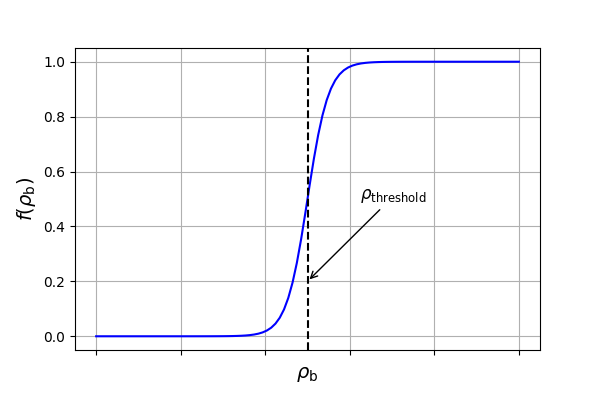

In [2]:
import matplotlib.pyplot as plt
from IPython.display import Image

outfig = "transition_function.png"

fig,ax = plt.subplots()

rho_b = np.linspace(0,10,100)
rho_threshold = 5
def f(rho_b,rho_threshold):
    return 0.5*(np.tanh((rho_b-rho_threshold)/(rho_threshold/10))+1)

ax.annotate(r"$\rho_{\rm threshold}$", xy=(5,0.2), xytext=(6.25,0.5),arrowprops=dict(arrowstyle="->"),fontsize=12)
ax.set_xticklabels([])
ax.set_xlabel(r"$\rho_{\rm b}$",fontsize=14)
ax.set_ylabel(r"$f(\rho_{\rm b})$",fontsize=14)
ax.grid()
ax.plot(rho_b,f(rho_b,rho_threshold),'blue')
ax.axvline(rho_threshold,ls='--',color='black')
plt.savefig(outfig,dpi=100)
plt.close(fig)
Image(outfig)

<a id=startup_f90></a>

# Step 10: `startup.F90` \[Back to [Top](#toc)\]
$$\label{startup_f90}$$

<a id=zelmanileak_startup></a>

## Step 10.a: `ZelmaniLeak_startup()` \[Back to [Top](#toc)\]
$$\label{zelmanileak_startup}$$

Initializes $\pnu$ to zero.

<a id=zelmanileak_startup_global></a>

## Step 10.b: `ZelmaniLeak_startup_global()` \[Back to [Top](#toc)\]
$$\label{zelmanileak_startup_global}$$

If using a tabulated $\bar{\ye}(\rhob)$, this functions allocates memory for the necessary gridfunctions and reads in $\bar{\ye}$ and $\rhob$ from file.

<a id=paramcheck_c></a>

# Step 11: `paramcheck.c` \[Back to [Top](#toc)\]
$$\label{paramcheck_c}$$

<a id=zelmanileak_paramcheck></a>

## Step 11.a: `ZelmaniLeak_ParamCheck()` \[Back to [Top](#toc)\]
$$\label{zelmanileak_paramcheck}$$

This function checks if storage has been allocated to all gridfunctions needed by the `ZelmaniLeak` thorn.

<a id=tmunu_f90></a>

# Step 12: `Tmunu.F90` \[Back to [Top](#toc)\]
$$\label{tmunu_f90}$$

<a id=zelmanileak_tmunu></a>

## Step 12.a: `ZelmaniLeak_Tmunu()` \[Back to [Top](#toc)\]
$$\label{zelmanileak_tmunu}$$

This function updates the energy-momentum tensor $T_{\mu\nu}$ according to Eq. (38) of [O'Connor & Ott (2010)](https://arxiv.org/abs/0912.2393), i.e.,

$$
T_{\mu\nu} = T_{\mu\nu}^{\rm GRMHD} + (\rhob\epsilon_{\rm neutrinos} + \pnu)u_{\mu}u_{\nu} + \pnu g_{\mu\nu}.
$$

To completely explain the implementation, we remind the reader that the input of the function is $v_{(n)}^{i}$, i.e., the Valencia three-velocity, related to the fluid four-velocity $u^{\mu}$ via

$$
u^{\mu} = W\left(n^{\mu}+v_{(n)}^{\mu}\right).
$$

where $v_{(n)}^{0}=0$, $n^{\mu}=\alpha^{-1}\bigl(1,-\beta^{i}\bigr)$, and $W = -n_{\mu}u^{\mu} = \alpha u^{0}$ is the [Lorentz factor](https://en.wikipedia.org/wiki/Lorentz_factor). Thus we have

$$
\begin{aligned}
u^{0} &= W/\alpha,\\
u^{i} &= W\left(\beta^{i}/\alpha+v_{(n)}^{i}\right).
\end{aligned}
$$

For the following discussion it is useful to remember that

$$
g_{\mu\nu} = 
\begin{pmatrix}
-\alpha^{2}+\beta_{\ell}\beta^{\ell} & \beta_{i}\\
\beta_{j} & \gamma_{ij}
\end{pmatrix}.
$$

where $\beta_{i}=\gamma_{ij}\beta^{j}$. We can now compute

$$
\begin{split}
u_{0} &= g_{0\mu}u^{\mu} = g_{00}u^{0} + g_{0i}u^{i}\\
&= (-\alpha^{2}+\beta^{j}\beta_{j})u^{0} + \beta_{i}W\left(\beta^{i}/\alpha+v_{(n)}^{i}\right)\\
&= (-\alpha^{2}+\beta^{j}\beta_{j})W/\alpha + W\beta^{i}\beta_{i}/\alpha + W\beta_{i}v_{(n)}^{i}\\
\implies&u^{0} = W(-\alpha + \beta_{i}v_{(n)}^{i}).
\end{split}
$$

Similarly,

$$
u_{i} = g_{i\mu}u^{\mu} = W g_{i\mu}\left(n^{\mu}+v_{(n)}^{\mu}\right) = W\left(n_{i}+v^{(n)}_{i}\right) = Wv^{(n)}_{i},
$$

where we have used $n_{\mu}=(\alpha,0)$. Thus

$$
u_{i} = W\gamma_{ij}v_{(n)}^{j}.
$$

The implemented expressions are thus

$$
\boxed{
\begin{aligned}
T_{00} &= T_{00}^{\rm GRMHD} + A u_{0}u_{0} + \bigl(-\alpha^{2}+\beta_{i}\beta^{i}\bigr)\pnu\\
T_{0i} &= T_{0i}^{\rm GRMHD} + A u_{0}v^{(n)}_{i} + \beta_{i}\pnu\\
T_{ij} &= T_{ij}^{\rm GRMHD} + A v^{(n)}_{i}v^{(n)}_{j} + \gamma_{ij}\pnu
\end{aligned}
}\; ,
$$

where the auxiliary variable $A$ (`tmunutemp` in the code) is defined as

$$
A \equiv W^{2}\bigl(\rhob\epsilon_{\rm neutrinos} + \pnu\bigr).
$$